# Tumor Analysis of Patient S0

Import Necessary Packages/Libraries.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

### Functions to process data

create_rdr_baf(self) is a function that selects the columns of interest for RDR and BAF by concatenating the chromosome, start, and end numbers into a single column and pivoting the data from long to wide. After the RDR and BAF are pivoted individually, they are inner-merged to create a new dataframe. This allows for easier analysis as the cell sequence is identified as the index with RDR and BAF inputs for the columns.

In [12]:
def create_rdr_baf(self):
    print(self['CELL'].unique().shape[0])
    crdr = self[['#CHR', 'START', 'END', 'CELL', 'RDR']] #Selects columns of interest for RDR
    
    pd.set_option('mode.chained_assignment', None) #Removes SettingwithCopyWarning 

    crdr['#CHR']= crdr['#CHR'].astype(str) 
    crdr['START']= crdr['START'].astype(str)
    crdr['END']= crdr['END'].astype(str)

    crdr["chr_start_end"]= crdr['#CHR'] + '_' + crdr["START"]+ '_' + crdr['END']  #Concatenates columns

    crdr = crdr.pivot(index='CELL', columns='chr_start_end', values='RDR')   #Pivots data from long to wide
    #print(crdr.shape)
    baf = self[['#CHR', 'START', 'END', 'CELL', 'BAF']] #Selects columns of interest for BAF

    pd.set_option('mode.chained_assignment', None) #Removes SettingwithCopyWarning 

    baf['#CHR']= baf['#CHR'].astype(str) 
    baf['START']= baf['START'].astype(str)
    baf['END']= baf['END'].astype(str)

    baf["chr_start_end"]= baf['#CHR'] + '_' + baf["START"]+ '_' + baf['END']  #Concatenates columns

    baf = baf.pivot(index='CELL', columns='chr_start_end', values='BAF')   #Pivots data from long to wide
    #print(baf.shape)
    x = crdr.merge(baf, how='inner', on='CELL')  #Concatenates columns
    #print(x.shape)
    return x

pca_df(df) is a function that performs the task of dimensionality reduction, specifically into 2 dimensions, creating a new dataframe with 'pca1' and 'pca2' columns. This is a significant step that allows for better analysis of the data.

In [3]:
def pca_df(df):
    pca = PCA(n_components=3)
    principalComponents = pca.fit_transform(df)
    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pca1', 'pca2', 'pca3'])
    return principalDf

### Read in process data

Read all the files from PatientS0 into a dictionary

In [4]:
datA = pd.read_csv("patientS0/calls/sectionA/calls.tsv.gz", sep="\t", compression="gzip" )
datB = pd.read_csv("patientS0/calls/sectionB/calls.tsv.gz", sep="\t", compression="gzip" )
datC = pd.read_csv("patientS0/calls/sectionC/calls.tsv.gz", sep="\t", compression="gzip" )
datD = pd.read_csv("patientS0/calls/sectionD/calls.tsv.gz", sep="\t", compression="gzip" )
datE = pd.read_csv("patientS0/calls/sectionE/calls.tsv.gz", sep="\t", compression="gzip" )
data = {'A': datA, 'B': datB,'C': datC,'D': datD,'E': datE}

Preprocess the data by transforming the data from wide to long with a column for each RDR and BAF and a row for a each cell. Use "SECTION-BARCODE" as the index.

In [13]:
final = []
total = 0
for d in data:
    x = create_rdr_baf(data[d])
    cell_id = d + "-" + data[d]['CELL'].unique() 
    total += cell_id.shape[0]
    x = x.reset_index()
    x = x.drop(columns=['CELL'])
    x['CELL'] = cell_id
    x = x.set_index("CELL")
    final.append(x)
print("total cells:" + str(total))
result_s0 = pd.concat(final)

2191
2239
1754
1943
2075
total cells:10202


Reduce the dimensionality of the data using PCA into 2 dimensions and create columns that indicate the section and barcode from the index.

In [6]:
pca_result = pca_df(result_s0)
pca_result.shape
pca_result['CELL'] = result_s0.index
pca_result['ID'] = result_s0.index
pca_result= pca_result.set_index("CELL")
pca_result[['SECTION','BARCODE']] = pca_result['ID'].str.split('-',expand=True)

Read the list of normal cells and add a variable for cell type.

In [7]:
normal_cells = pd.read_csv('/scratch/projects/mudoublet/chisel-data/patientS0/normal_cells.txt', header=None, names=['CELL'])
normal_cells = normal_cells.set_index("CELL")
normal_cells["TYPE"] = "NORMAL"

Left join pca_result with normal cells data and replace NA in TYPE column wtih tumor.

In [8]:
pca_result = pca_result.join(normal_cells, how="left")
print(pca_result.shape)
pca_result = pca_result.fillna({"TYPE":"TUMOR"})

(10202, 7)


Count the number of cells of each type in the dataset.

In [9]:
pca_result.groupby("TYPE").count()

,pca1,pca2,pca3,ID,SECTION,BARCODE
TYPE,,,,,,
NORMAL,4239,4239,4239,4239,4239,4239
TUMOR,5963,5963,5963,5963,5963,5963


### Visualization of Tumor Analysis

Visualize scatterplot with points colored by cell type and faceted by section

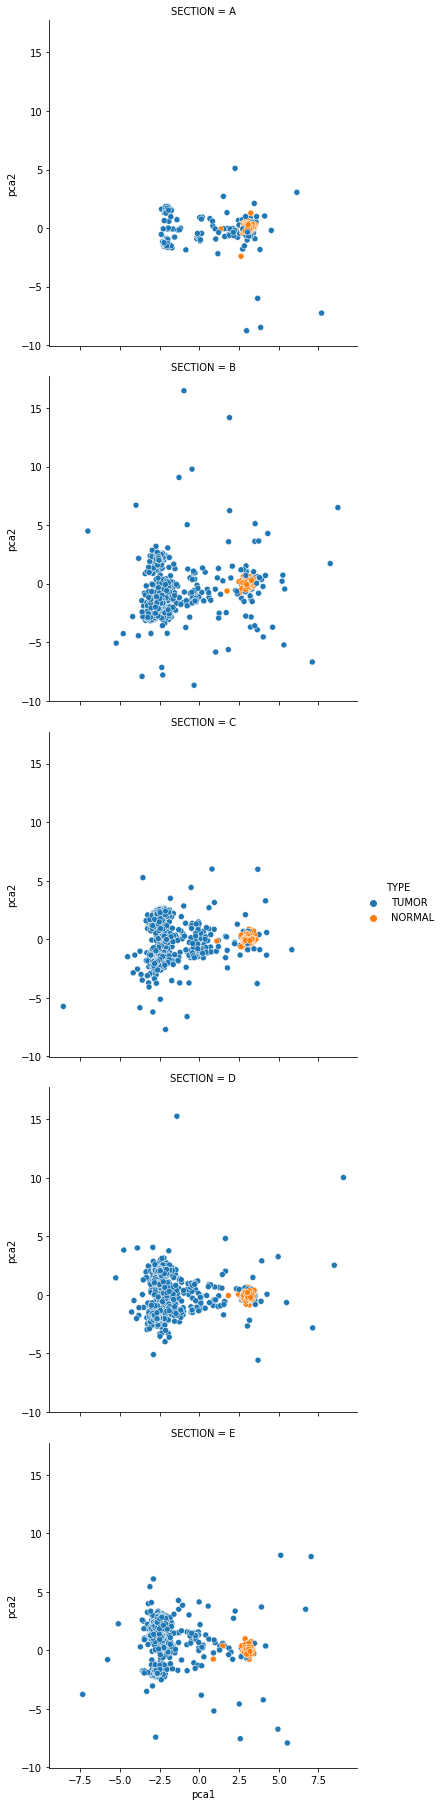

In [10]:
sns.relplot(x = 'pca1', y = 'pca2', hue='TYPE', row="SECTION", data=pca_result)

Visualize scatterplot for all cells with each point colored by cell type

In [14]:
pca_result

,pca1,pca2,pca3,ID,SECTION,BARCODE,TYPE
CELL,,,,,,,
A-AAACCTGAGATCTGCT,-2.174447,-1.257057,-0.194343,A-AAACCTGAGATCTGCT,A,AAACCTGAGATCTGCT,TUMOR
A-AAACCTGGTACCGCTG,3.107686,0.120226,0.725817,A-AAACCTGGTACCGCTG,A,AAACCTGGTACCGCTG,NORMAL
A-AAACCTGGTGCTGTAT,3.014673,-0.075404,1.208958,A-AAACCTGGTGCTGTAT,A,AAACCTGGTGCTGTAT,NORMAL
A-AAACCTGTCCGCGGAT,3.814865,-1.831104,13.685118,A-AAACCTGTCCGCGGAT,A,AAACCTGTCCGCGGAT,TUMOR
A-AAACGGGCATGTATGC,2.872225,0.052243,1.222268,A-AAACGGGCATGTATGC,A,AAACGGGCATGTATGC,NORMAL
...,...,...,...,...,...,...,...
E-TTTGTCAAGTAGATGT,-2.138523,2.276121,0.447487,E-TTTGTCAAGTAGATGT,E,TTTGTCAAGTAGATGT,TUMOR
E-TTTGTCACAATTCACG,-2.266904,2.151739,-0.258926,E-TTTGTCACAATTCACG,E,TTTGTCACAATTCACG,TUMOR
E-TTTGTCATCGAAATCC,2.977089,-0.323400,-0.629726,E-TTTGTCATCGAAATCC,E,TTTGTCATCGAAATCC,NORMAL


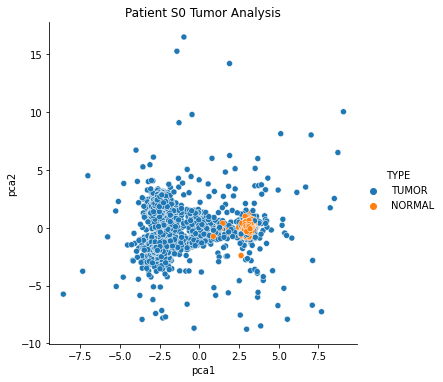

In [11]:
sns.relplot(x = 'pca1', y = 'pca2', hue='TYPE',data=pca_result).set(title='Patient S0 Tumor Analysis')